In [1]:
from qiskit.pulse import pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse

import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from pulse_commands import *

from scipy.optimize import curve_fit

In [9]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_johannesburg')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

ibmqfactory.load_account:WARNING:2020-07-06 15:26:13,329: Credentials are already in use. The existing account in the session will be replaced.


In [10]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [11]:
qb = 0
us = 1.0e-6 # Microseconds
scale_factor = 1e-14

time_max_us = 450
time_step_us = 6
times_us = np.arange(1, time_max_us, time_step_us)

delay_times_dt = times_us * us / config.dt

drive_chan = qiskit.pulse.DriveChannel(qb)
meas_chan = qiskit.pulse.MeasureChannel(qb)
acq_chan = qiskit.pulse.AcquireChannel(qb)
circ_inst_map = defaults.instruction_schedule_map
measure = circ_inst_map.get('measure', qubits=qb)

t1_schedules = []
for delay in delay_times_dt:
    sched = qiskit.pulse.Schedule(name=f'T1 delay + {delay * config.dt/us} us')
    sched += qiskit.pulse.Play(SamplePulse(Xp(qb).samples, name=f'Xp{qb}'), drive_chan)
    sched |= measure << int(delay)
    t1_schedules.append(sched)

# Execution settings
num_shots = 512

t1_experiment = assemble(t1_schedules,
                        backend=backend, 
                        meas_level=1,
                        meas_return='avg',
                        shots=num_shots,
                        schedule_los=[{drive_chan: defaults.qubit_freq_est[qb]}] * len(t1_schedules))

job = backend.run(t1_experiment)

In [12]:
# job = backend.retrieve_job('5ee924323fe92c001a26c653')

In [13]:
t1_results = job.result(timeout=120)

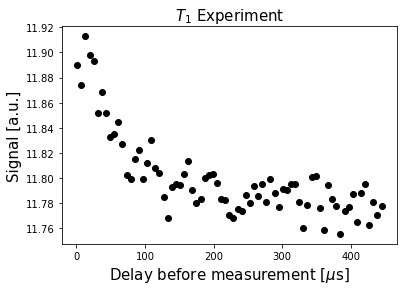

In [14]:
t1_values = []
for i in range(len(times_us)):
    t1_values.append(t1_results.get_memory(i)[qb]*scale_factor)
t1_values = np.real(t1_values)

plt.scatter(times_us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

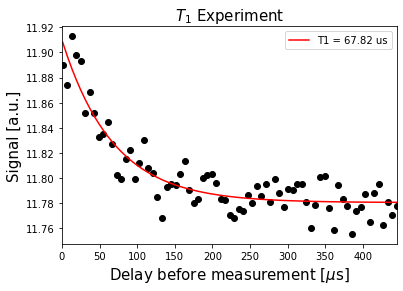

In [15]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()